# Preliminary analysis of RCA in vivo conditions

In [1]:
import os, sys
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

import cv2
import skimage
import scipy.ndimage, scipy.stats

In [2]:
from cellpose import models

## Set up directory

In [3]:
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250417_eGFP_re_in_vivo_RCA/500nm_test/tif/i7"

# list of all files in the directory
files = os.listdir(data_dir)
files = [os.path.join(data_dir, f) for f in files if f.endswith('.tif')]
files.sort()
files

['/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250417_eGFP_re_in_vivo_RCA/500nm_test/tif/i7/ROI_008_deconvoluted.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250417_eGFP_re_in_vivo_RCA/500nm_test/tif/i7/ROI_009_deconvoluted.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250417_eGFP_re_in_vivo_RCA/500nm_test/tif/i7/ROI_010_deconvoluted.tif']

In [110]:
file = files[2]
print(file)
img = tif.imread(file)
img_i27 = img[3,:,:]
img_nuc = img[5,:,:]


/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250417_eGFP_re_in_vivo_RCA/500nm_test/tif/i7/ROI_010_deconvoluted.tif


## Exploratory analysis

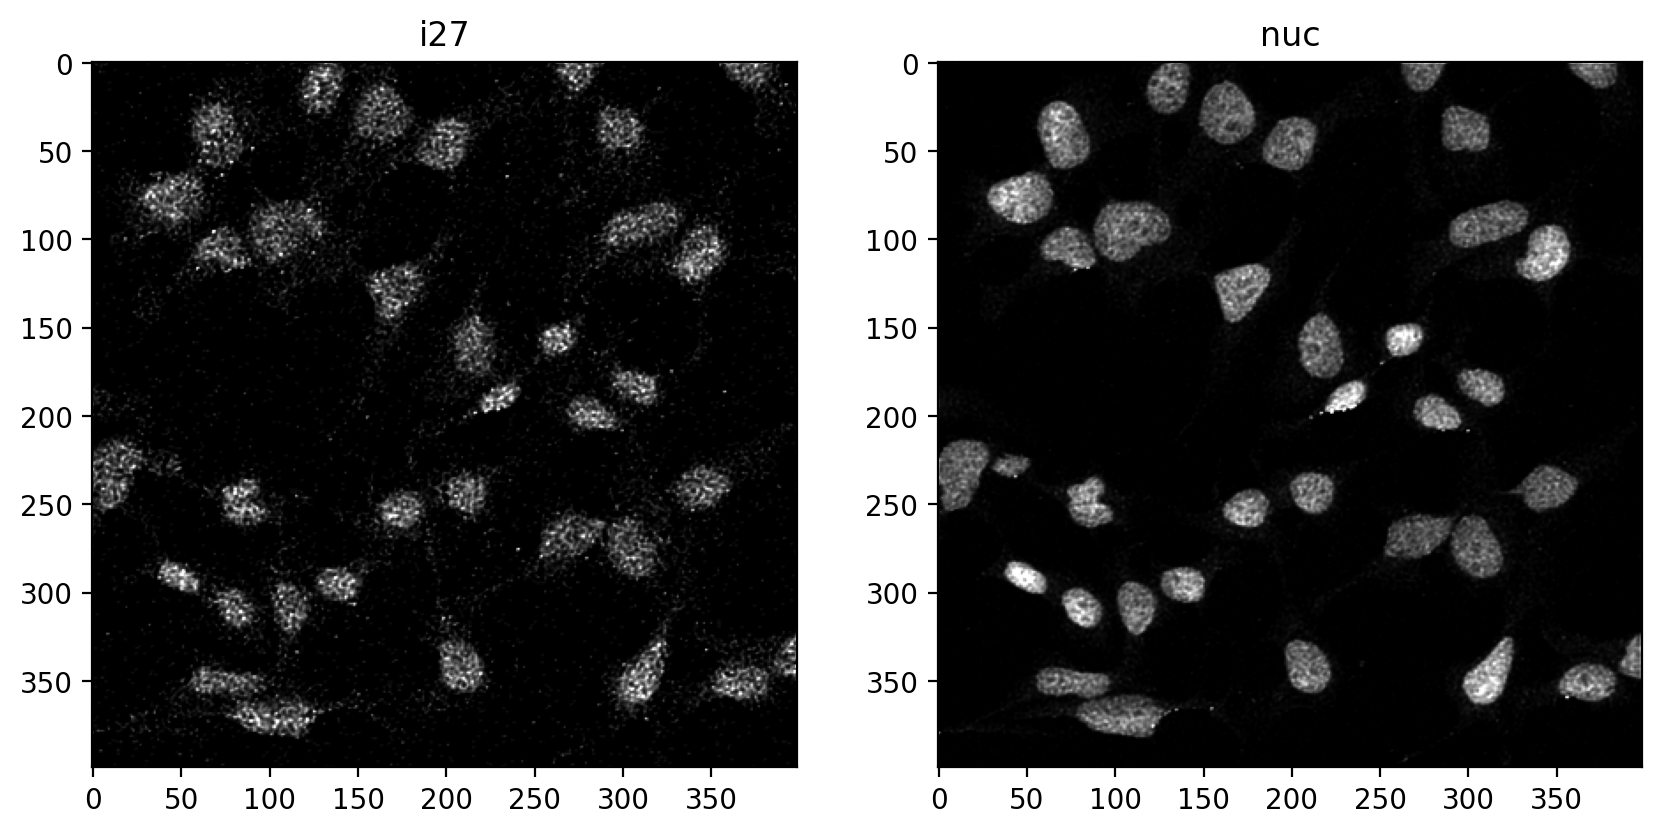

In [111]:
plt.figure(figsize=(10, 5), dpi=200)
plt.subplot(121)
plt.imshow(img_i27, cmap='gray')
plt.clim(np.percentile(img_i27, 5), np.percentile(img_i27, 99.9))
plt.title("i27")
plt.subplot(122)
plt.imshow(img_nuc, cmap='gray')
plt.clim(np.percentile(img_nuc, 5), np.percentile(img_nuc, 99.9))
plt.title("nuc")
plt.show()

Plot a line profile in the diagonal direction

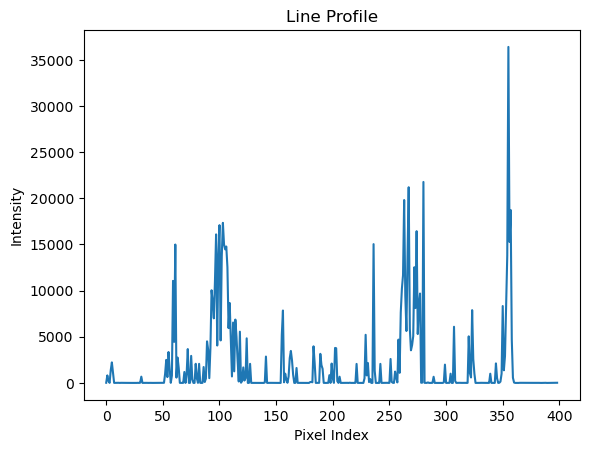

In [112]:
def plot_line_profile(img, start, end):
    # Create a mask for the line
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.line(mask, start, end, 255, 1)

    # Get the coordinates of the line
    coords = np.column_stack(np.where(mask > 0))

    # Get the pixel values along the line
    line_values = img[coords[:, 0], coords[:, 1]]

    # Plot the line profile
    plt.plot(line_values)
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.title('Line Profile')
    plt.show()
# Define the start and end points of the line
start = (0, 0)
end = (img_i27.shape[1] - 1, img_i27.shape[0] - 1)
# Plot the line profile for the first image
plot_line_profile(img_i27, start, end)

## Nuclear segmentation

Get the nuc mask so that the DNA nonspecific signal can be masked out from the analysis

In [113]:
model = models.Cellpose(model_type="nuclei")

In [114]:
channels = [[0, 0]]

masks, flows, styles, diams = model.eval(img_nuc, diameter=20, channels = channels)

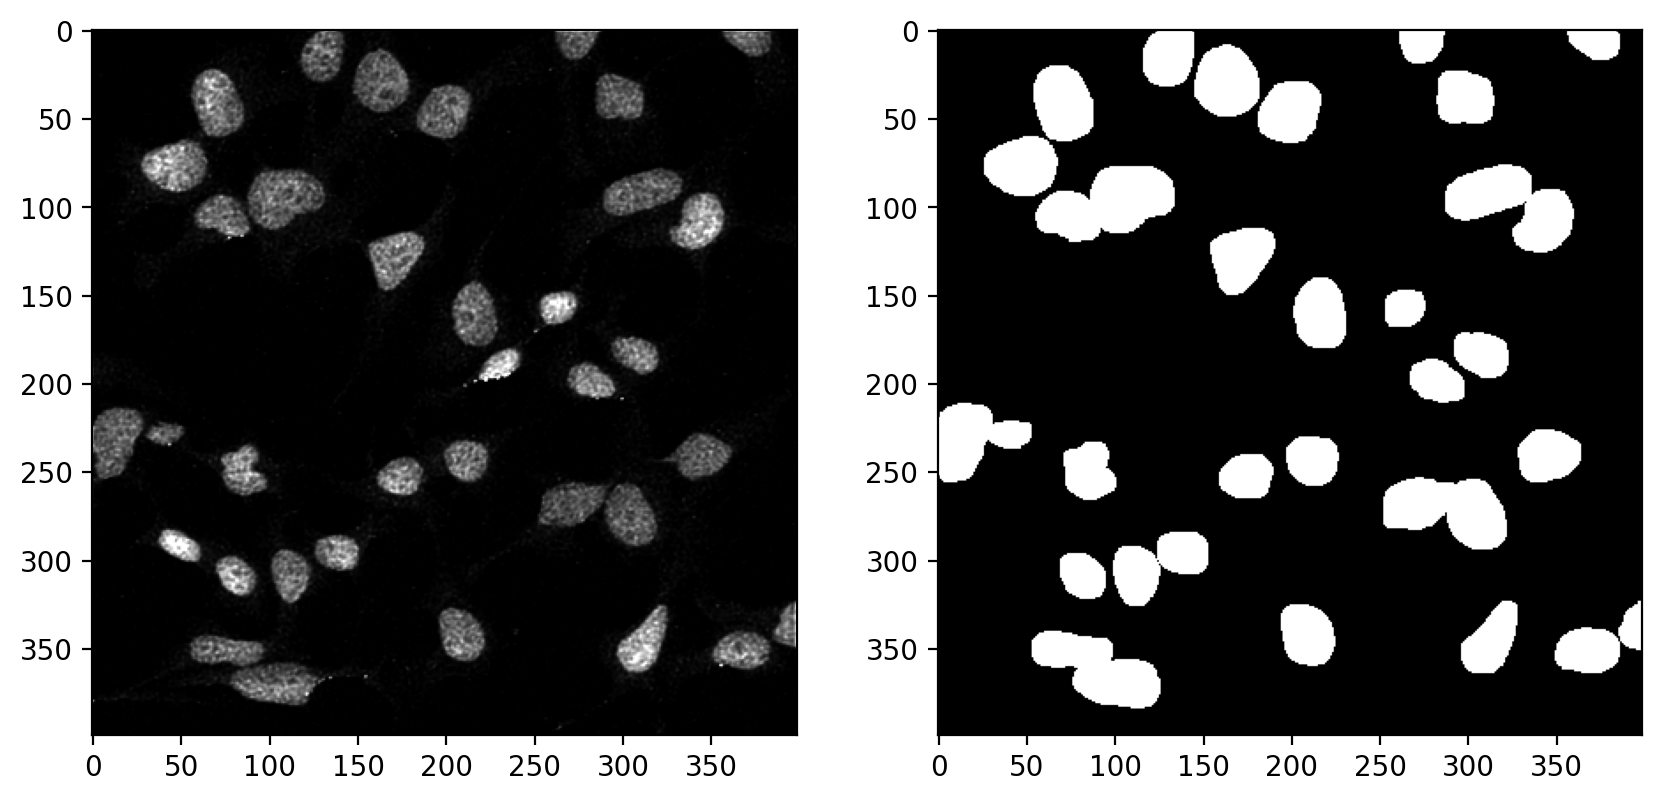

In [115]:
nuc_bmask = masks > 0
# dilate the mask
kernel = np.ones((3, 3), np.uint8)
nuc_bmask = cv2.dilate(nuc_bmask.astype(np.uint8), kernel, iterations=2)

plt.figure(figsize=(10, 5), dpi=200)
plt.subplot(121)
plt.imshow(img_nuc, cmap='gray')
plt.clim(np.percentile(img_nuc, 5), np.percentile(img_nuc, 99.9))
plt.subplot(122)
plt.imshow(nuc_bmask, cmap='gray')
plt.clim(0, 1)
plt.show()

## Amplicon masking and binarization

Difference of guassian and then local maxima to detect spots

In [116]:
def vis_gaussian(img, sigma1, sigma2):
    # difference of guassian sigma1 = 2, sigma2 = 10
    img_sig1 = skimage.filters.gaussian(img, sigma=sigma1, preserve_range=True)
    img_sig2 = skimage.filters.gaussian(img, sigma=sigma2, preserve_range=True)
    img_sub = img_sig1 - img_sig2
    
    return img_sub

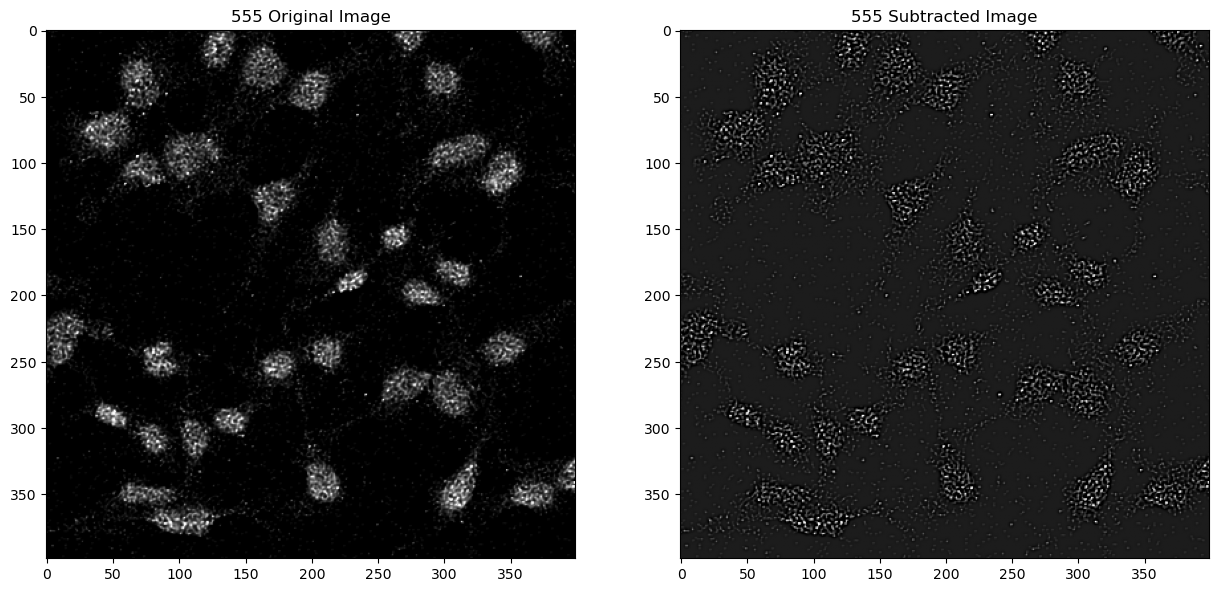

In [117]:
sigma_1 = 0.5
sigma_2 = 1


img_i27_sub = vis_gaussian(img_i27, sigma_1, sigma_2)

plt.figure(figsize=(15, 13), dpi=100)
plt.subplot(121)
plt.imshow(img_i27, cmap='gray')
plt.title('555 Original Image')
plt.clim(np.percentile(img_i27, 5), np.percentile(img_i27, 99.9))
# plt.axis('off')
plt.subplot(122)
plt.imshow(img_i27_sub, cmap='gray')
plt.title('555 Subtracted Image')
plt.clim(np.percentile(img_i27_sub, 5), np.percentile(img_i27_sub, 99.9))
# plt.axis('off')


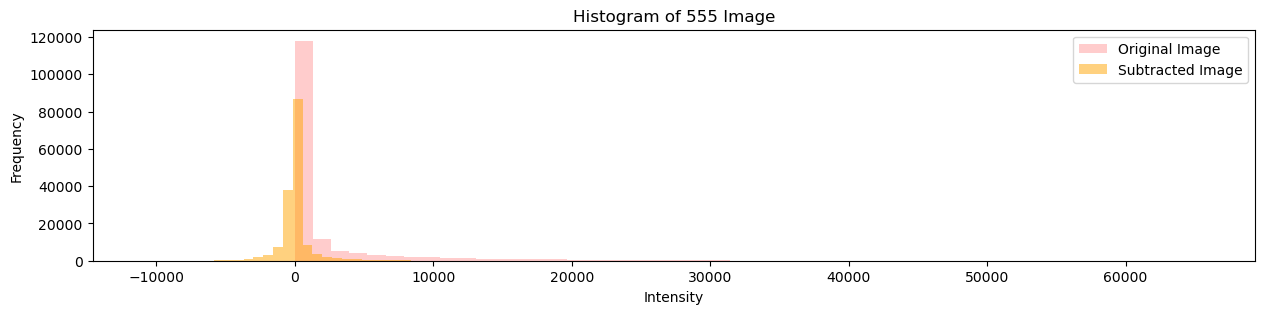

In [118]:

# plot the histogram before and after background subtraction
plt.figure(figsize=(15, 3), dpi=100)
# plt.hist(img_i27_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_i27.flatten(), bins=50, color='red', alpha=0.2, label='Original Image')
plt.hist(img_i27_sub.flatten(), bins=50, color='orange', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 555 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Local max (circular kernel)

In [119]:
def maximum_filter(img, radius):
    # set a circular kernel
    kernel = cv2.circle(np.zeros((radius*2+1, radius*2+1), dtype=np.uint8), (radius, radius), radius, 1, -1)
    
    # apply the maximum filter using the circular kernel, consider a reflective border
    img_max = cv2.dilate(img, kernel, iterations=1)
    return img_max

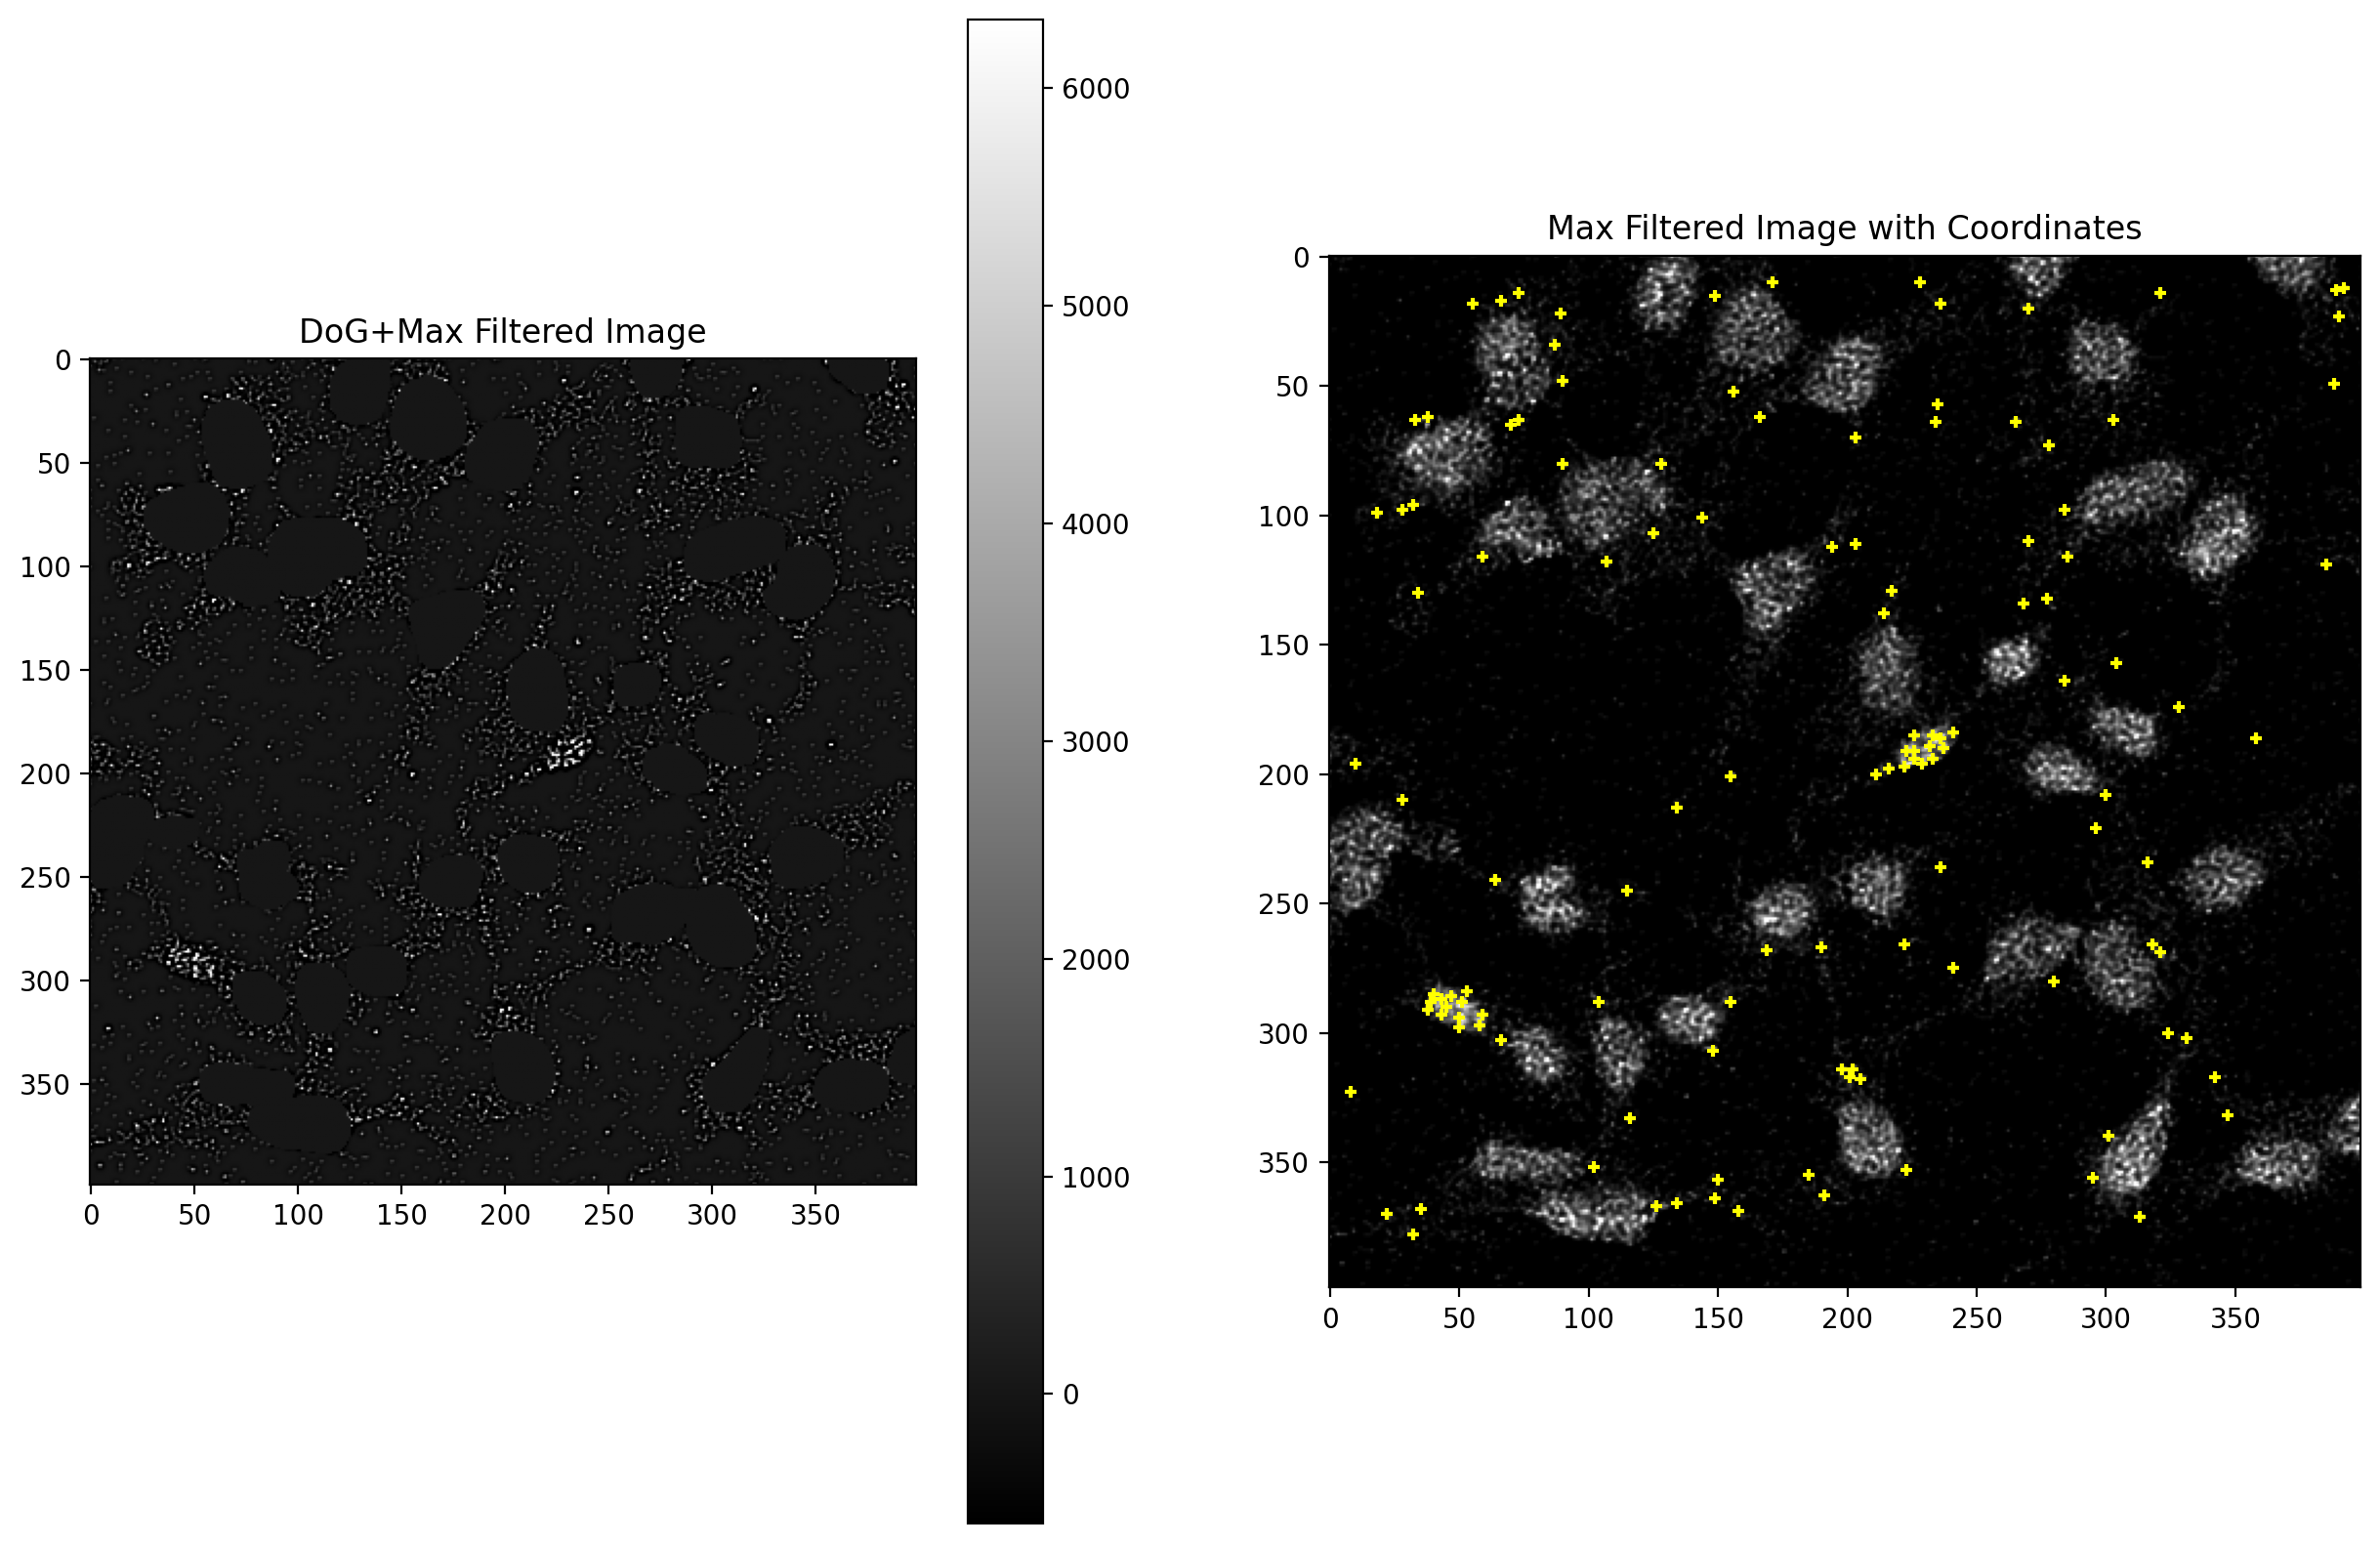

In [123]:
img_i27_sub[nuc_bmask>0] = 0
img_i27_max = maximum_filter(img_i27_sub, radius=0)
thres = 6000
coordinates = skimage.feature.peak_local_max(img_i27_sub, min_distance=2, threshold_abs=thres)

plt.figure(figsize=(15, 10), dpi=200)
plt.subplot(121)
plt.imshow(img_i27_max, cmap='gray')
plt.title('DoG+Max Filtered Image')
plt.clim(np.percentile(img_i27_max, 5), np.percentile(img_i27_max, 99.9))
# plt.xlim(500, 1000)
# plt.ylim(2000, 1500)
plt.colorbar()

plt.subplot(122)
plt.imshow(img_i27, cmap='gray')
plt.title('Max Filtered Image with Coordinates')
plt.clim(np.percentile(img_i27, 5), np.percentile(img_i27, 99.9))

# plt.colorbar()
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')
    
# plt.xlim(500, 1000)
# plt.ylim(2000, 1500)
    
plt.show()

whole-amplicon intensity correlation

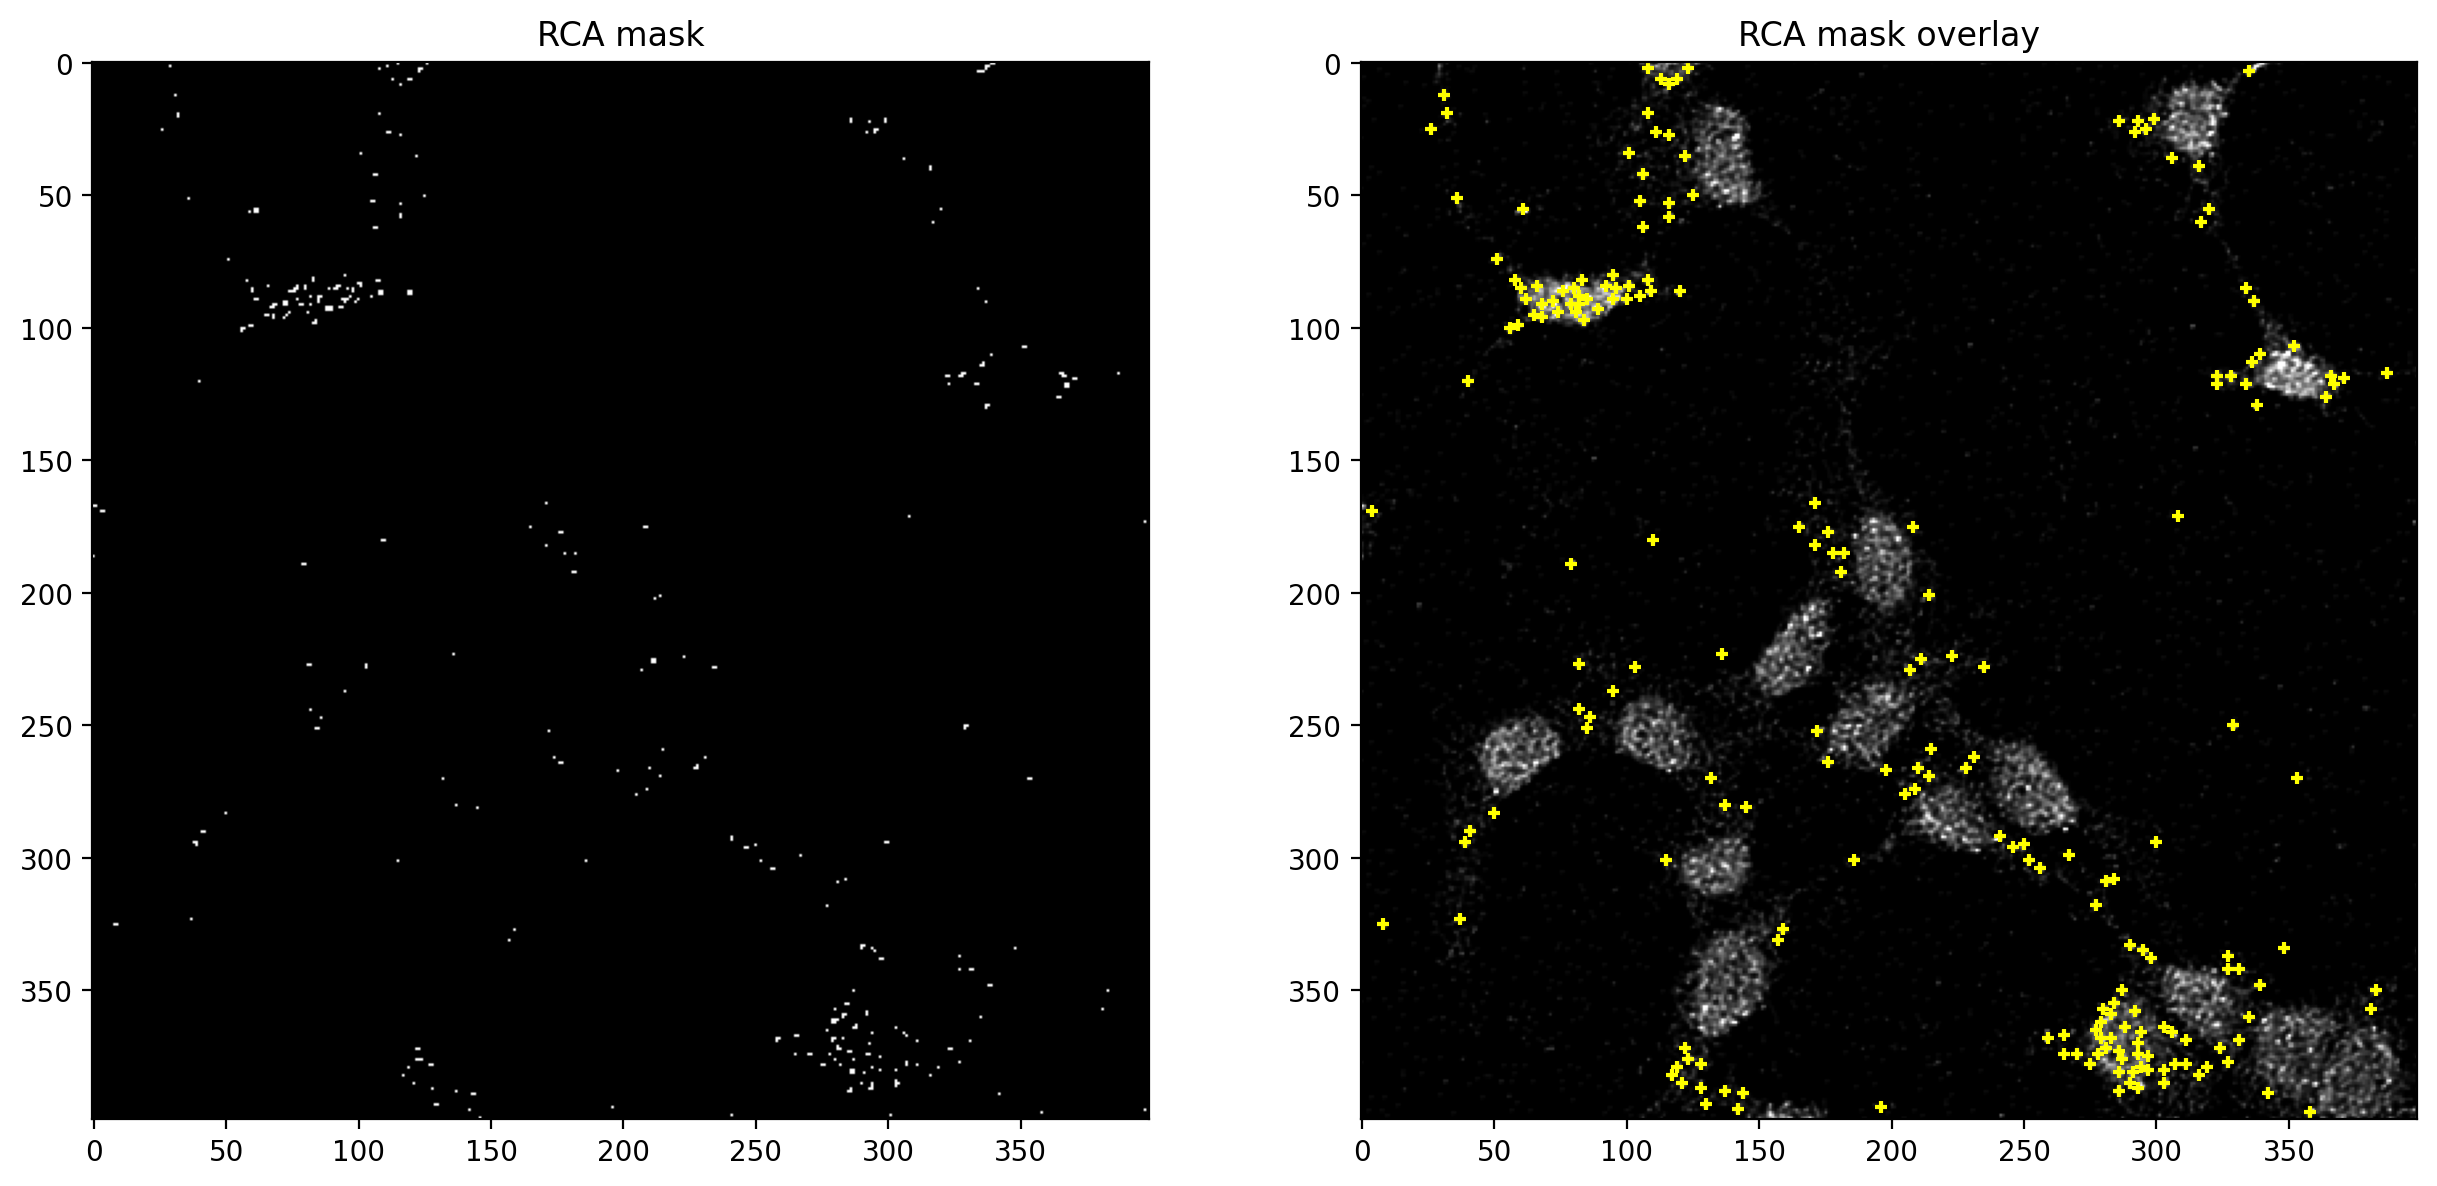

In [109]:
img_mask = img_i27_max > thres

plt.figure(figsize=(15, 10), dpi = 200)
plt.subplot(121)
plt.imshow(img_mask, cmap='gray')
plt.title('RCA mask')
plt.clim(0, 1)
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)

plt.subplot(122)
plt.imshow(img_i27, cmap='gray')
plt.title('RCA mask overlay')
plt.clim(np.percentile(img_i27, 5), np.percentile(img_i27, 99.9))
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)
plt.show()

In [48]:
# turn the mask into a label image
img_mask = skimage.measure.label(img_mask)
img_i27_df = skimage.measure.regionprops_table(img_mask, img_i27, properties=['label', 'centroid', 'area', 'mean_intensity'])

In [49]:
amp_df = pd.DataFrame(img_i27_df)

# add one column to store area*mean_intensity as total_intensity
amp_df['total_intensity'] = amp_df['area'] * amp_df['mean_intensity']

# change the column name "centroid-0" to "y"
amp_df.rename(columns={'centroid-0': 'y'}, inplace=True)
# change the column name "centroid-1" to "x"
amp_df.rename(columns={'centroid-1': 'x'}, inplace=True)

amp_df

label           y           x  area  mean_intensity  total_intensity
0        1   28.000000   40.500000   2.0     7890.000000          15780.0
1        2   43.500000  144.000000   2.0    10687.500000          21375.0
2        3   50.000000   99.000000   1.0     9105.000000           9105.0
3        4   52.333333  140.666667   3.0    12549.333333          37648.0
4        5   54.000000  321.000000   1.0    12169.000000          12169.0
..     ...         ...         ...   ...             ...              ...
100    101  322.000000  118.000000   1.0    11193.000000          11193.0
101    102  341.000000  379.500000   2.0    11037.500000          22075.0
102    103  347.000000   77.000000   1.0     9391.000000           9391.0
103    104  359.000000   87.000000   1.0    11704.000000          11704.0
104    105  378.000000  188.000000   1.0     7010.000000           7010.0

[105 rows x 6 columns]

## Cytosol masking and binarization

In [94]:
model = models.Cellpose(model_type="cyto")

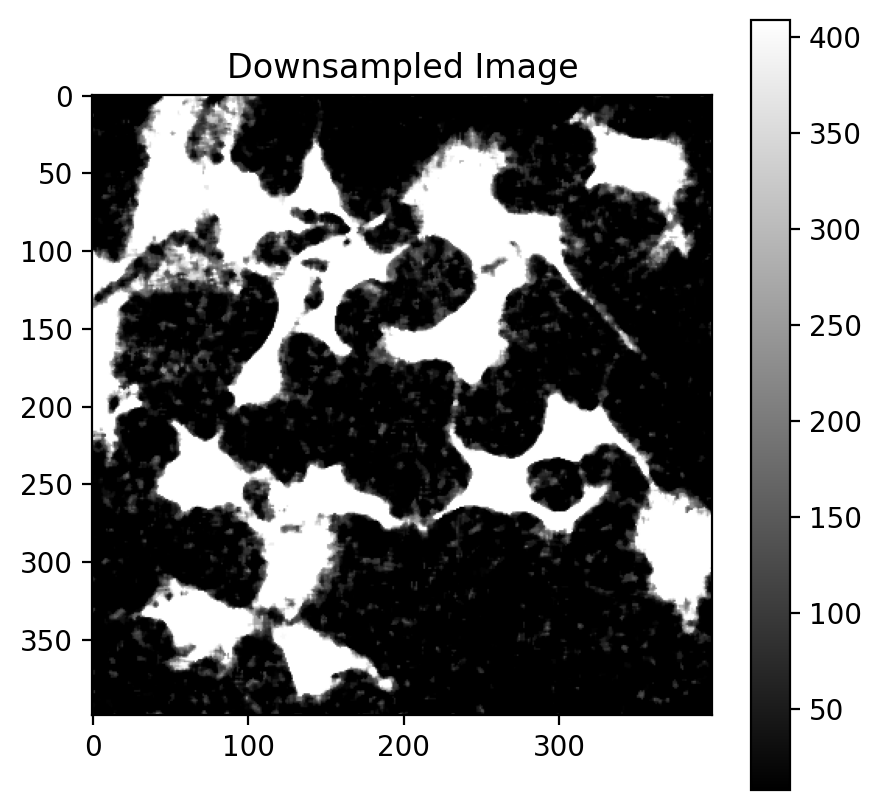

In [91]:
img_cellpose = img[5,:,:]
# downsample the image to 1/4
# img_cellpose = skimage.transform.rescale(img_cellpose, 1/4, anti_aliasing=True)

# clip the image to max percentile 80
img_cellpose = np.clip(img_cellpose, np.percentile(img_cellpose, 40), np.percentile(img_cellpose, 75))
# median filter the image
img_cellpose = skimage.filters.median(img_cellpose, np.ones((5, 5)))
# show the downsampled image
plt.figure(figsize=(5, 5), dpi=200)
plt.imshow(img_cellpose, cmap='gray')
plt.colorbar()
# plt.clim(np.percentile(img_cellpose, 5), np.percentile(img_cellpose, 80))
plt.title('Downsampled Image')
plt.show()


In [95]:
channels = [[0, 0]]

masks, flows, styles, diams = model.eval(img_cellpose, diameter=None, channels = channels)

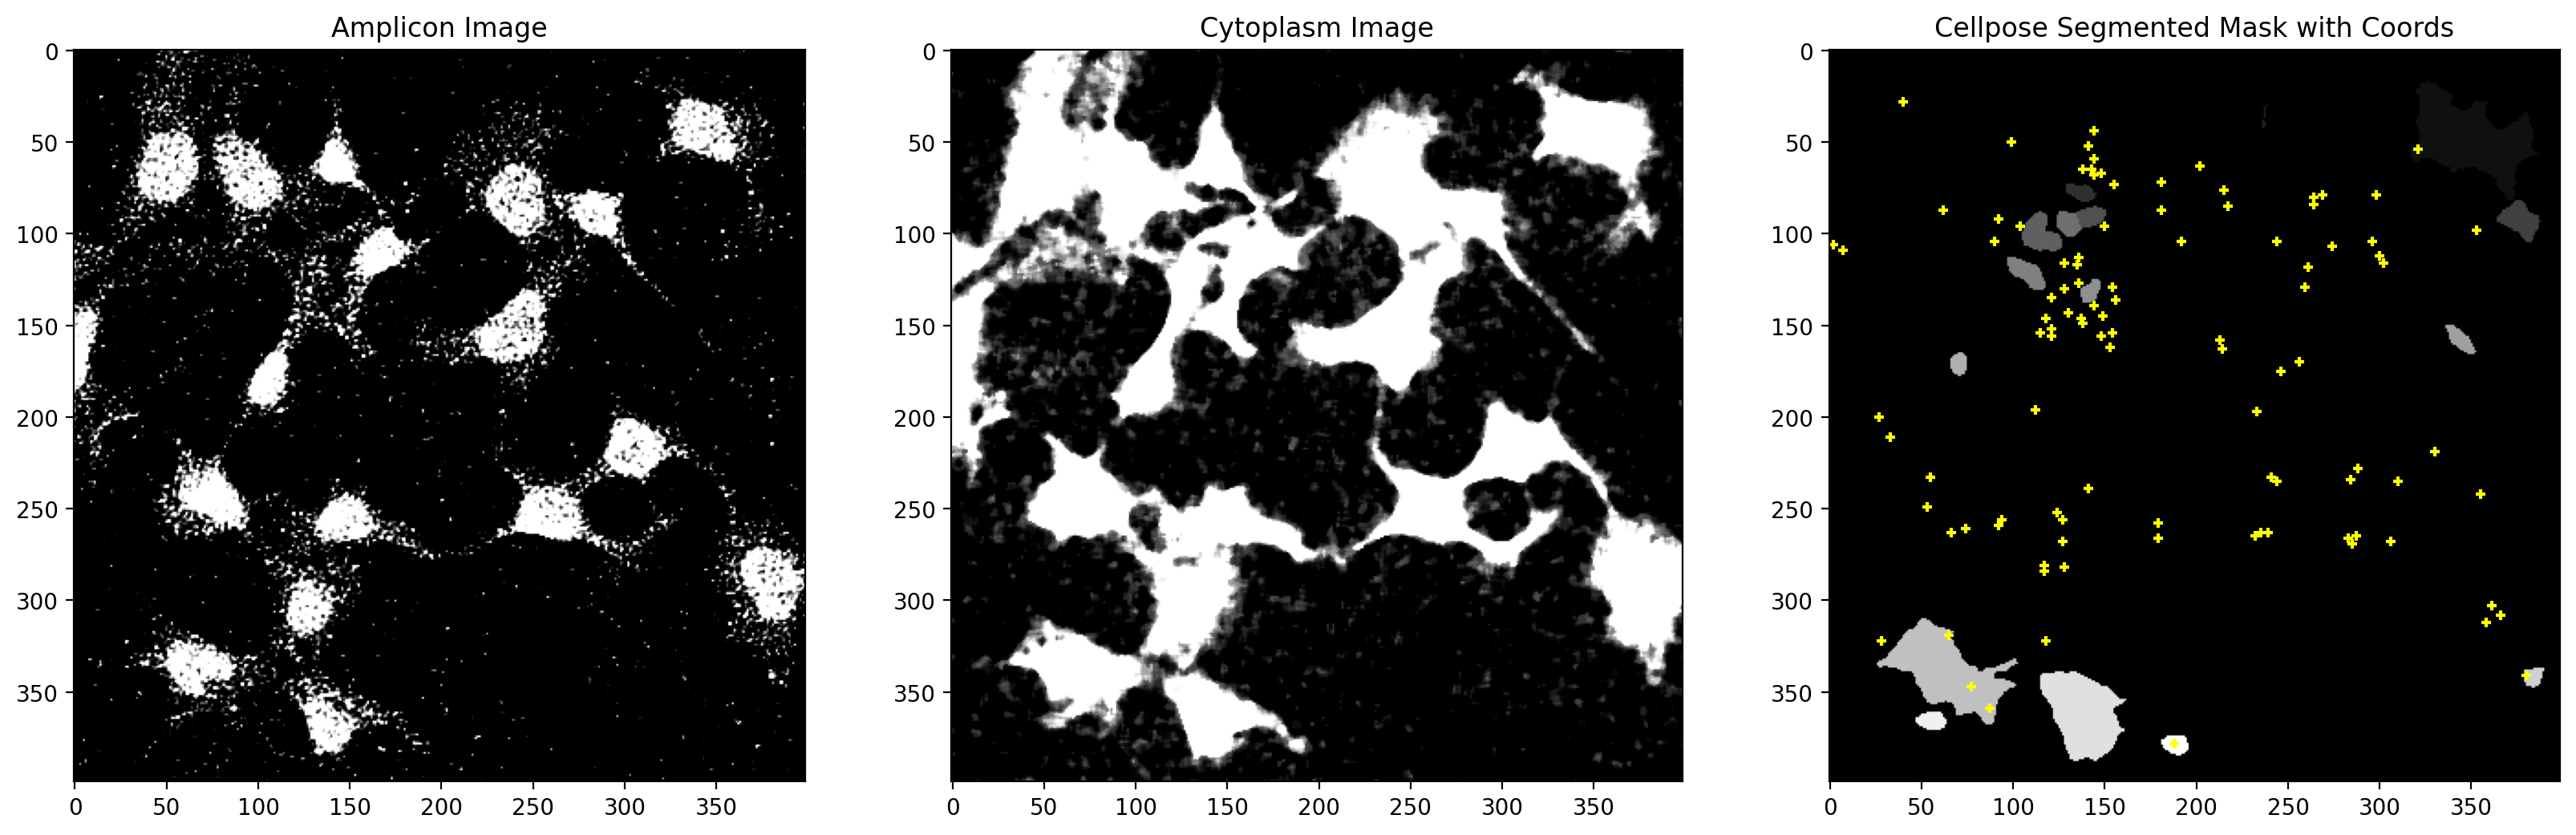

In [96]:
plt.figure(figsize=(20, 10), dpi=200)
plt.subplot(131)
plt.imshow(img_i27, cmap='gray')
plt.title('Amplicon Image')
plt.clim(500, 2000)
plt.subplot(132)
plt.imshow(img_cellpose, cmap='gray')
plt.title('Cytoplasm Image')
plt.clim(np.percentile(img_cellpose, 5), np.percentile(img_cellpose, 99.9))
plt.subplot(133)
plt.imshow(masks, cmap='gray')
plt.title('Cellpose Segmented Mask with Coords')
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')

plt.show()

In [134]:
# generate a df for the cellpose mask
cyto_df = skimage.measure.regionprops_table(masks, img_cellpose, properties=['label', 'centroid', 'area', 'mean_intensity'])
cyto_df = pd.DataFrame(cyto_df)

cyto_df['total_intensity'] = cyto_df['area'] * cyto_df['mean_intensity']

# change the column name "centroid-0" to "y"
cyto_df.rename(columns={'centroid-0': 'y'}, inplace=True)
# change the column name "centroid-1" to "x"
cyto_df.rename(columns={'centroid-1': 'x'}, inplace=True)

cyto_df

label            y            x     area  mean_intensity  total_intensity
0       1    37.278029   501.583784   9053.0     3773.480946       34161323.0
1       2   181.513805  2028.042844   3151.0     2103.325611        6627579.0
2       3   303.622015   698.212311  18633.0     2829.475071       52721609.0
3       4   506.876204  1458.674893  12359.0     9316.394368      115141318.0
4       5   533.836461   669.553593  17213.0     2924.521524       50339789.0
5       6   505.864454    24.897994   2892.0     6072.196404       17560792.0
6       7   619.995101  1929.752014  30417.0     4690.047934      142657188.0
7       8   621.859817  1293.043979  26922.0     6972.180707      187705049.0
8       9   758.579219   991.786899  15129.0     4244.911494       64221266.0
9      10   793.327035  1485.975856  10479.0    10410.816776      109094949.0
10     11   754.117354  1965.042143  14878.0     3309.933728       49245194.0
11     12  1037.390453  1503.572815  11543.0     4998.205666       57694288.0
12     13  1053.293891   560.416496  16598.0     4430.287987       73533920.0
13     14  1114.425292   267.859575   5227.0     3330.222881       17407075.0
14     15  1251.064568   207.788784   9308.0    10521.448002       97933638.0
15     16  1290.746925  1807.249121  25040.0     4552.150479      113985848.0
16     17  1334.827670  1649.765191  15157.0     8053.982186      122074208.0
17     18  1406.545819   345.431327  17940.0     7000.858082      125595394.0
18     19  1401.580365  1191.500418  17937.0     3558.560350       63829897.0
19     20  1544.966761   856.309988  12365.0    19992.483704      247207061.0
20     21  1600.684092  1094.307654   3998.0     2559.938969       10234636.0
21     22  1592.636026   727.634963   3764.0     3731.060308       14043711.0
22     23  1736.040932   618.041151  18250.0     9625.409699      175663727.0
23     24  1710.740701   756.881447  17663.0     5363.272547       94731483.0
24     25  1712.660557  1455.499167   4201.0     1335.985718        5612476.0

## Cell-dependent amplicon analysis

In [135]:
# for each mask (with label) in the cellpose mask, find the corresponding RCA mask, add the "amplicon_count" column to the cyto_df, add the "cyto_label" column to the amp_df
cyto_df['amplicon_count'] = 0
amp_df['cyto_label'] = 0

for i in range(len(cyto_df)):
    # get the label of the cellpose mask
    label = cyto_df['label'][i]
    amp_count = 0
    for j in range(len(amp_df)):
        amp_x = amp_df['x'][j].astype(int)
        amp_y = amp_df['y'][j].astype(int)
        amp_label = masks[amp_y, amp_x]
        if amp_label == label:
            amp_count += 1
            amp_df.loc[j, 'cyto_label'] = label
    cyto_df.loc[i, 'amplicon_count'] = amp_count
cyto_df['amplicon_count'] = cyto_df['amplicon_count'].astype(int)
amp_df['cyto_label'] = amp_df['cyto_label'].astype(int)

In [136]:
cyto_df

label            y            x     area  mean_intensity  total_intensity  \
0       1    37.278029   501.583784   9053.0     3773.480946       34161323.0   
1       2   181.513805  2028.042844   3151.0     2103.325611        6627579.0   
2       3   303.622015   698.212311  18633.0     2829.475071       52721609.0   
3       4   506.876204  1458.674893  12359.0     9316.394368      115141318.0   
4       5   533.836461   669.553593  17213.0     2924.521524       50339789.0   
5       6   505.864454    24.897994   2892.0     6072.196404       17560792.0   
6       7   619.995101  1929.752014  30417.0     4690.047934      142657188.0   
7       8   621.859817  1293.043979  26922.0     6972.180707      187705049.0   
8       9   758.579219   991.786899  15129.0     4244.911494       64221266.0   
9      10   793.327035  1485.975856  10479.0    10410.816776      109094949.0   
10     11   754.117354  1965.042143  14878.0     3309.933728       49245194.0   
11     12  1037.390453  1503.572815  11543.0     4998.205666       57694288.0   
12     13  1053.293891   560.416496  16598.0     4430.287987       73533920.0   
13     14  1114.425292   267.859575   5227.0     3330.222881       17407075.0   
14     15  1251.064568   207.788784   9308.0    10521.448002       97933638.0   
15     16  1290.746925  1807.249121  25040.0     4552.150479      113985848.0   
16     17  1334.827670  1649.765191  15157.0     8053.982186      122074208.0   
17     18  1406.545819   345.431327  17940.0     7000.858082      125595394.0   
18     19  1401.580365  1191.500418  17937.0     3558.560350       63829897.0   
19     20  1544.966761   856.309988  12365.0    19992.483704      247207061.0   
20     21  1600.684092  1094.307654   3998.0     2559.938969       10234636.0   
21     22  1592.636026   727.634963   3764.0     3731.060308       14043711.0   
22     23  1736.040932   618.041151  18250.0     9625.409699      175663727.0   
23     24  1710.740701   756.881447  17663.0     5363.272547       94731483.0   
24     25  1712.660557  1455.499167   4201.0     1335.985718        5612476.0   

    amplicon_count  
0               15  
1                0  
2               19  
3               35  
4               28  
5                5  
6               24  
7               71  
8               17  
9               27  
10              22  
11              16  
12              22  
13              18  
14              11  
15              25  
16              29  
17              34  
18              11  
19              35  
20              10  
21              11  
22              48  
23              11  
24               0

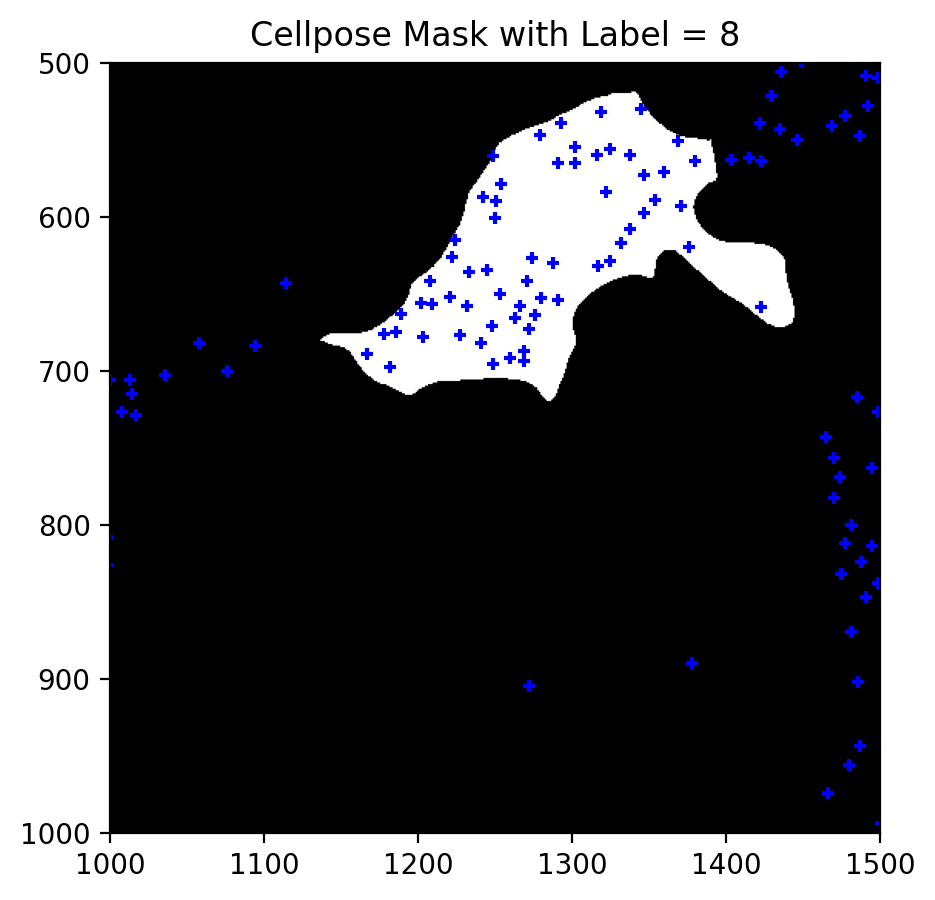

In [137]:
# show mask with label = 8
plt.figure(figsize=(5, 5), dpi=200)
plt.imshow(masks == 8, cmap='gray')
plt.title('Cellpose Mask with Label = 8')
plt.clim(0, 1)

for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='blue', s=20, marker = '+')

plt.xlim(1000, 1500)
plt.ylim(1000, 500)
plt.show()

In [138]:
# compute the proportion of amplicons with label = 0 and > 0
total_amplicons = len(amp_df)
cyto_amplicons  = cyto_df['amplicon_count'].sum()

proportion_cyto = cyto_amplicons / total_amplicons

print(f"Amplicons within cytoplasm: {cyto_amplicons} / {total_amplicons} = {proportion_cyto:.2f}")


Amplicons within cytoplasm: 544 / 695 = 0.78


Boxplot of how amplicon count distribution looks like

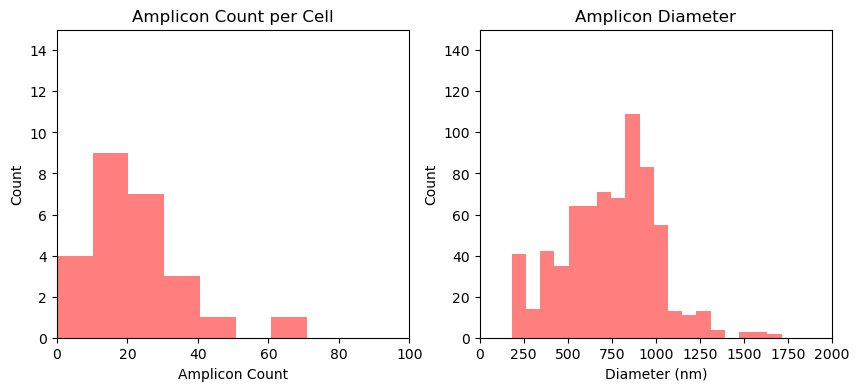

In [139]:
# plot a histogram of the amplicon count for each cellpose label
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.hist(cyto_df['amplicon_count'], bins='auto', color='red', alpha=0.5, label='Amplicon Count per Cell', density=False)
plt.title('Amplicon Count per Cell')
plt.xlim(0, 100)
plt.ylim(0, 15)
plt.xlabel('Amplicon Count')
plt.ylabel('Count')

# plot a histogram of the area for each amplicon
plt.subplot(122)
voxel_size = 0.1618437
diameter = np.sqrt(amp_df['area']/np.pi) * 2 * voxel_size * 1000
plt.hist(diameter, bins='auto', color='red', alpha=0.5, label='Amplicon diameter', density=False)
plt.xlim(0, 2000)
plt.ylim(0, 150)
plt.title('Amplicon Diameter')

plt.xlabel('Diameter (nm)')
plt.ylabel('Count')
plt.show()


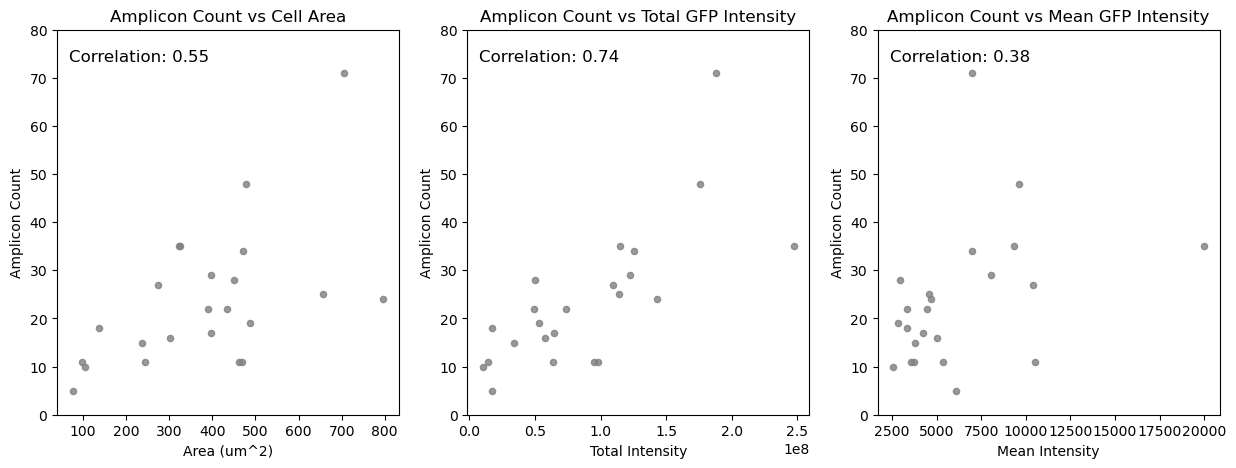

In [140]:
# remove those with amplicon count = 0
cyto_df_filtered = cyto_df[cyto_df['amplicon_count'] > 0]

# plot a scatter plot of amplicon count vs area
plt.figure(figsize=(15, 5), dpi=100)
plt.subplot(131)
plt.scatter(cyto_df_filtered['area'] * voxel_size**2, cyto_df_filtered['amplicon_count'], c='gray', alpha=0.8, s=20)
# add correlation value
corr = np.corrcoef(cyto_df_filtered['area'] * voxel_size**2, cyto_df_filtered['amplicon_count'])[0, 1]
plt.text(0.24, 0.93, f'Correlation: {corr:.2f}', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.ylim(0, 80)
plt.title('Amplicon Count vs Cell Area')
plt.xlabel('Area (um^2)')
plt.ylabel('Amplicon Count')

plt.subplot(132)
plt.scatter(cyto_df_filtered['total_intensity'], cyto_df_filtered['amplicon_count'], c='gray', alpha=0.8, s=20)
# add correlation value
corr = np.corrcoef(cyto_df_filtered['total_intensity'], cyto_df_filtered['amplicon_count'])[0, 1]
plt.text(0.24, 0.93, f'Correlation: {corr:.2f}', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.ylim(0, 80)
plt.title('Amplicon Count vs Total GFP Intensity')
plt.xlabel('Total Intensity')
plt.ylabel('Amplicon Count')

# plot a scatter plot of amplicon count vs mean intensity
plt.subplot(133)
plt.scatter(cyto_df_filtered['mean_intensity'], cyto_df_filtered['amplicon_count'], c='gray', alpha=0.8, s=20)
# add correlation value
corr = np.corrcoef(cyto_df_filtered['mean_intensity'], cyto_df_filtered['amplicon_count'])[0, 1]
plt.text(0.24, 0.93, f'Correlation: {corr:.2f}', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.ylim(0, 80)
plt.title('Amplicon Count vs Mean GFP Intensity')
plt.xlabel('Mean Intensity')
plt.ylabel('Amplicon Count')
plt.show()